## Create a list containing the GAIA IDs of the objects within a given radius from a sky position

Documentation:

https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products

In [ ]:
!pip install astroquery
from astroquery.gaia import GaiaClass
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import GaiaClass
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.io import fits

#[......]

gaiaobj = GaiaClass()
gaiaobj.ROW_LIMIT = 100000

# Corrected: Pass the coordinate string directly, not in a list
#M103 (NGC 581) has an apparent dimension of about 6 arcminutes (6')
coord = SkyCoord("1:33:12 +60:42:00", unit=(u.hourangle, u.degree))
#radius: 3 arcmin are 3 * 1/60 = 1/20 degree BUT in this way we select
#not enough stars (just 53), so, we use the radius used by the professor
#to create the catalouge: 1/3 degree
radius = 1/3

#Query Gaia catalogue
job = gaiaobj.cone_search(coord, radius = radius * u.deg, verbose=False)
results = job.get_results()

objwithspec = (results['has_xp_sampled'])
results = results[objwithspec]

print('Number of stars with XP spectra: {}'.format(len(results)))

Number of stars with XP spectra: 992


In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob
from astropy.wcs import WCS
from astropy.table import Table
from scipy.integrate import quad
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive/', force_remount=True)
path = "/content/drive/My Drive/Data Acquisition"
path_member = "/content/drive/My Drive/Data Acquisition/M103_membership_selected.fits"
hdul_member = fits.open(path_member)
catalogue = Table.read(path_member)

Mounted at /content/drive/


In [ ]:
print(results[0])
print(catalogue[0])

    solution_id             designation             source_id      random_index ref_epoch         ra           ra_error         dec         dec_error       parallax      parallax_error parallax_over_error     pm            pmra         pmra_error         pmdec        pmdec_error ra_dec_corr ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr astrometric_n_obs_al astrometric_n_obs_ac astrometric_n_good_obs_al astrometric_n_bad_obs_al astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig astrometric_params_solved astrometric_primary_flag nu_eff_used_in_astrometry pseudocolour pseudocolour_error ra_pseudocolour_corr dec_pseudocolour_corr parallax_pseudocolour_corr pmra_pseudocolour_corr pmdec_pseudocolour_corr astrometric_matched_transits visibility_periods_used astrometric_sigma5d_max matched_transits new_matched_transits matched_transits_removed ipd_gof_ha

In [ ]:
# python
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import hstack

#match_to_catalogue_sky di sky coordinate al posto del ciclo for

# This is the function that finds which GAIA stars with spectra are in the cluster.
# I define a max_sep_degrees, which is the maximum separation in positions (GAIA position and my observed position)
# that an object can have to be classified as 'an object observed by my telescope that has also been observed by GAIA'.
# In this way I find which stars (that I have observed) have a spectrum measured by GAIA

def match_tables_by_radec(table1, table2,
                          ra1='ra', dec1='dec',
                          ra2='RAdeg', dec2='DEdeg',
                          coord_unit=u.deg,
                          max_sep_degree=1.5/3600):
  joined = []
  for i in range(len(table1)):
    for j in range(len(table2)):
      if np.abs(table1[i][ra1] - table2[j][ra2]) <= max_sep_degree and np.abs(table1[i][dec1] - table2[j][dec2]) <= max_sep_degree:
          joined.append(table1[i])
  return joined


In [ ]:
#Read existing table of cluster members

# I cross-match the GAIA catalogue (results) with my data (catalogue_file)
# I need to put results as the FIRST variable because the function returns the data of the stars saved in in the first variable
joined = match_tables_by_radec(results, catalogue, ra1='ra', dec1='dec', ra2='RAdeg', dec2='DEdeg', max_sep_degree=3/3600)
joined = Table(joined)
print(results.colnames)

joined = joined[np.array(joined['teff_gspphot']) != 0]

# I save the list of starID, RA, Dec and logTeff of the stars from the cross-match
starID = np.array(joined['source_id'])
starRA = np.array(joined['ra'])
starDEC = np.array(joined['dec'])
logTeff = np.array(np.log10(joined['teff_gspphot']))
Teff = np.array(joined['teff_gspphot'])

print('Number of matched stars between Gaia and member catalog: {}'.format(len(joined)))
#print(joined)

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_transits', 

In [ ]:
Teff

array([12079.83007812, 13349.86425781,  7316.98535156, 10286.56640625,
       15068.00488281,  9603.30957031, 10210.99414062,  8152.04931641,
        9475.31640625, 13337.30859375])

## Download the spectra and save them in FITS files for further processing:

This cell is used for unpacking the data of the GAIA catalogue (limiting it to the stars from the cross-match) and for saving them in the directory GAIAdef as fits files with the names 'GAIADR3_{}.fits'.

In the meantime, I save the arrays with wavelengths, fluxes and flux_errors for each star (strwave, strflux, strfluxerr).

In [ ]:
retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
writedir = '/content/drive/My Drive/Data Acquisition/Spec/GAIA/'

datalink = gaiaobj.load_data(ids=starID,
                          data_release=data_release,
                          retrieval_type=retrieval_type,
                          data_structure=data_structure,
                          format='votable',
                          verbose=True,
                          dump_to_file=False)

dl_keys  = [key for key in datalink.keys()]

strwave = []
strflux = []
strfluxerr = []

for ind, strid in enumerate(starID):
         for dl_key in dl_keys:
              if '{}'.format(strid) in dl_key:
                wave = datalink[dl_key][0].to_table().as_array()['wavelength']
                wave = np.ma.getdata(wave)
                flux = datalink[dl_key][0].to_table().as_array()['flux']
                flux = np.ma.getdata(flux)
                fluxerror = datalink[dl_key][0].to_table().as_array()['flux_error']
                fluxerror = np.ma.getdata(fluxerror)
                #Append to lists
                strwave.append(wave)
                strflux.append(flux)
                strfluxerr.append(fluxerror)

         #Save in fits file
         hdu1 = fits.PrimaryHDU(flux)
         hdu1.header['SRCID'] = starID[ind]
         hdu1.header['RA'] = starRA[ind]
         hdu1.header['DEC'] = starDEC[ind]
         hdu1.header['FUNIT'] = 'W/m2/nm'
         hdu1.header['CRVAL1'] = wave[0]
         hdu1.header['CD1_1'] = wave[1]-wave[0]
         hdu1.header['CTYPE1'] = 'Wavelength'
         hdu1.header['CUNIT1'] = 'nm'
         hdu2 = fits.ImageHDU(fluxerror)
         hdu3 = fits.ImageHDU(strwave)
         hdulist = fits.HDUList([hdu1, hdu2, hdu3])
         hdulist.writeto(writedir+'GAIADR3_{}.fits'.format(starID[ind]), overwrite=True)

         #strwave, strflux, strfluxerr remain populated so they can be used but if your kernel has to be restarted, you can read back the FITS files.


Retrieving data.
Data request: VALID_DATA=false&ID=509863234241688960%2C509863268601430912%2C509863199881962368%2C509863165522228224%2C509863023774655232%2C509875088351414784%2C509863131162496896%2C509863062443024896%2C509862753205377536%2C509862856284596864&RELEASE=Gaia+DR3&DATA_STRUCTURE=INDIVIDUAL&FORMAT=votable&RETRIEVAL_TYPE=XP_SAMPLED&USE_ZIP_ALWAYS=true
------>https
host = gea.esac.esa.int:443
context = /data-server/data
Content-type = application/x-www-form-urlencoded
200 200
Reading...
Done.


## Use Teff to find the best template and compare to the observed spectrum to find the attenuation curve


I save the spectra of stars (there is a spectrum for each temperature). These spectra are saved in the directory Stellarlib and they are models without dust attenuation.

In [ ]:
path_spec = "/content/drive/My Drive/Data Acquisition/Spec/StellarLib/"

TEFF = []
FLUX = []
#WAVE = []

for filename in os.listdir(path_spec):
  filepath = os.path.join(path_spec, filename)
  hdul_spec = fits.open(filepath)
  TEFF.append(hdul_spec[0].header['TEFF'])
  FLUX.append(hdul_spec[0].data)
  #WAVE.append(hdul_spec[2].data)

print(TEFF)

[3500, 4500, 4000, 5500, 5000, 6000, 6500, 7500, 7000, 8500, 8000, 9500, 9000, 10000, 10500, 11000, 11500, 12000, 12500, 13500, 13000, 14500, 14000, 15000, 16000, 17000, 18000, 19000, 19500]


In [ ]:
# Now, the problem is that I have the 'models' array (spectra without dust attenuation)
# and the 'strflux' array (spectra with dust attenuation form GAIA). But the spectra have not an order.
# To compare two spectra associated to the same star, I need to order my spectra using... Star temperatures!
# So I take the temperature of the star (Teff) and I search for the model with the closest temperature (Teff_model).
tot_extinction = []
for i in range(len(Teff)):
  mindiff_index = np.argmin(np.abs(Teff[i] - TEFF))
  # In order to find the model with the closest temperature, I find the index of the model with the tempearture
  # that minimizes the difference between Teff_model and Teff. Than I save the model corresponding to min_index
  # in the array selected_models. Now I can use this array to compare spectra associated to the same star.
  extinction = FLUX[mindiff_index]/strflux[i]
  tot_extinction.append(extinction)

tot_extinction = np.array(tot_extinction)
# I have the values of extinction vs wavelength for each star.
# To find a single value for the extinction vs wavelength, I compute the mean
mean_extinction = np.mean(tot_extinction, axis=0)

print(mean_extinction)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.93286034e+23 4.85946518e+23
 5.05787843e+23 4.93457384e+23 4.65631519e+23 4.59945832e+23
 4.79634718e+23 5.00509399e+23 4.93920908e+23 4.69796275e+23
 4.51563649e+23 4.44336766e+23 4.42103424e+23 4.39336014e+23
 4.33255717e+23 4.27595524e+23 4.29556032e+23 4.31250745e+23
 4.23222759e+23 4.06337706e+23 3.89103759e+23 3.81286789e+23
 3.87483195e+23 4.01591791e+23 4.14684591e+23 4.17396700e+23
 4.10113512e+23 4.02878891e+23 4.05281960e+23 4.09115461e+23
 4.08142305e+23 4.01209142e+23 3.92506043e+23 3.85886541e+23
 3.82810434e+23 3.82437947e+23 3.82230622e+23 3.80085587e+23
 3.75764457e+23 3.69379191e+23 3.62904919e+23 3.57008985e+23
 3.52516996e+23 3.503115

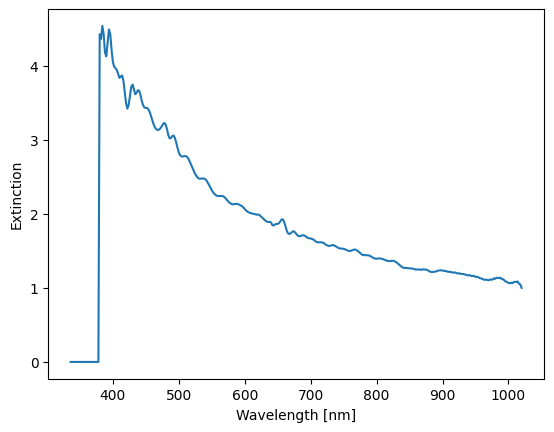

In [ ]:
plt.plot(strwave[0],mean_extinction/mean_extinction[-1])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Extinction')
plt.show()

Now I normalize the extinction:

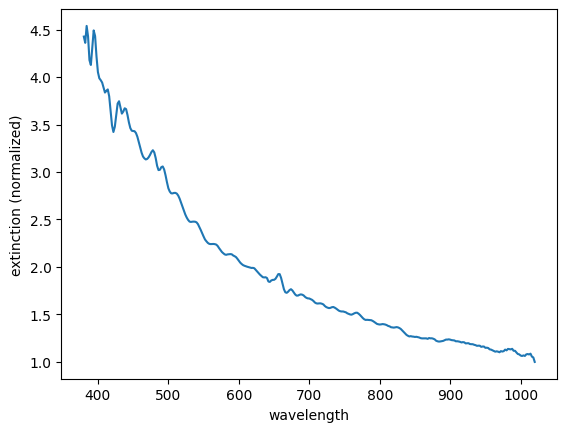

In [ ]:
# I neglect the values for which the extinction is = 0
mask = mean_extinction > 0
m_extinction = mean_extinction[mask]
starwave = strwave[0][mask]

# Normalized extinction
normal_extinction = m_extinction/m_extinction[-1]

plt.plot(starwave, normal_extinction)
plt.xlabel('wavelength')
plt.ylabel('extinction (normalized)')
plt.show()

## 'Translation Factor' for the color
Remember that at the end of the analysis of M103 we plotted the isochrones in the magnitude vs color diagram. We needed to perform a translation along the x-axis (color+0.70) to correct for dust effects.

Now, thanks to the following process, it is possible to compute the translations that must be applied in the color direction and we can compare them to the ones that we found by eye (0.70 for the G-R color).

In [ ]:
# Useful constants
c = 3*10**18
l_r = 6500
l_g = 4500
l_i = 8000

# Function to convert the flux into magnitude
def mag(filter, flux_star):
  l = eval(f'l_{filter}')   # I define the correct wavelength
  flux_nu = flux_star * l**2 / c
  magnitude = -2.5*np.log10(flux_nu)-48.6
  return magnitude

In [ ]:
path = "/content/drive/My Drive/Data Acquisition/"


# Function that computes the translation factor for each filter
def Factor(filter, starwave, extinction):
  sim = Table.read(path+f"{filter}_transmission.txt", format='ascii.basic')

  # I save the data related to my flux as a function of the wavelength into the arrays wav and trans
  wav = sim["Wavelength(A)"]
  trans = sim["Transmission(QE*Filter)"] # efficienza di quanto passano bene gli elettroni

  x = starwave * 10 # I need wavelengths in Angstrom
  trans_interp = np.interp(x, wav, trans)

  Num = np.trapezoid(extinction*trans_interp, x)
  Den = np.trapezoid(trans_interp, x)
  # np.trapezoid integrates the function (first parameter) along the x axis (second parameter).
  # In our case the x axis is GAIAspectrum[1].data, which contains the sample points (wavelengths)
  # corresponding to the y values (flux*transmission, transmission).
  factor = Num/Den

  return factor

In [ ]:
x_trasl_r = Factor('R', starwave, normal_extinction)
x_trasl_g = Factor('G', starwave, normal_extinction)
x_trasl_i = Factor('I', starwave, normal_extinction)

# I convert the fluxes into magnitudes
mag_r = mag('r', x_trasl_r)
mag_g = mag('g', x_trasl_g)
mag_i = mag('i', x_trasl_i)

# Translation along the color axis
color_gr = mag_g - mag_r
color_gi = mag_g - mag_i

In [ ]:
print(color_gr)
print(color_gi)

0.31769041073561866
0.4779084049531228
